# Statistics

In [1]:
import csv
import pandas as pd
import numpy as np

import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.model_selection import LeaveOneOut

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

In [2]:
datcsv = open('cleaned.txt','r')
dat = csv.reader(datcsv, delimiter = ' ',quotechar='"')
df = pd.DataFrame(next(dat))
df = df.transpose()

for i in dat:
    df_ = pd.DataFrame([i])
    df = pd.concat([df, df_])

datcsv.close()

In [3]:
df.columns = ['school', 'name', 'citedby', 'title', 'year']
df['year'] = pd.to_numeric(df['year'])
df['citedby'] = pd.to_numeric(df['citedby'])
df = df.reset_index(drop = True)

In [8]:
# citations per year
cit_per_yr = []

for i in range(len(df)):
    years_ago = 2018 - df.year[i]
    if years_ago == 0:
        c = df.citedby[i]
    else:
        c = df.citedby[i]/years_ago
    cit_per_yr.append(c)

df['cit_per_yr'] = cit_per_yr

In [10]:
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """Extract simple lemmas based on tokenization and stemming"""
    return stem(tokenize(text))

In [11]:
#vectorize the text i.e. convert the strings to numeric features
vectorizer = TfidfVectorizer(tokenizer=lemmatize, stop_words='english')
X = vectorizer.fit_transform(df['title'])

In [12]:
# From Lecture 9 in class
def loo_risk(X,y,regmod):
    """
    Construct the leave-one-out square error risk for a regression model
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar LOO risk
    """
    loo = LeaveOneOut()
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regmod.fit(X_train,y_train)
        y_hat = regmod.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)

def emp_risk(X,y,regmod):
    """
    Return the empirical risk for square error loss
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar empirical risk
    """
    regmod.fit(X,y)
    y_hat = regmod.predict(X)
    return np.mean((y_hat - y)**2)

In [14]:
y = np.array(df.cit_per_yr)

LOOs = []
MSEs = []

Ks = range(1,21,2)

for k in Ks:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    LOOs.append(loo_risk(X,y,knn))
    MSEs.append(emp_risk(X,y,knn))

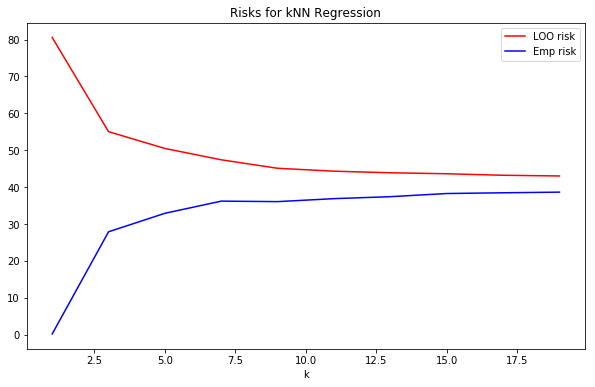

In [15]:
plt.plot(Ks,LOOs,'r',label="LOO risk")
plt.title("Risks for kNN Regression")
plt.plot(Ks,MSEs,'b',label="Emp risk")
plt.legend()
_ = plt.xlabel('k')